# Semantic segmentation. Medical photoes




---


We will work with dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>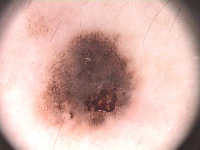</td><td>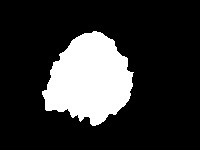</td></tr></table>



These are photos of two types of **skin lesions:** melanoma and moles.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!wget -c https://www.kaggle.com/datasets/kanametov/ph2dataset

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-11-23 08:27:53--  https://www.kaggle.com/datasets/kanametov/ph2dataset
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘ph2dataset’

ph2dataset              [ <=>                ]   8.41K  --.-KB/s    in 0s      

2023-11-23 08:27:54 (192 MB/s) - ‘ph2dataset’ saved [8607]



In [ ]:
!unzip -q /content/gdrive/MyDrive/archive.zip

replace PH2Dataset/PH2_Dataset/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

gdrive	PH2Dataset  sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

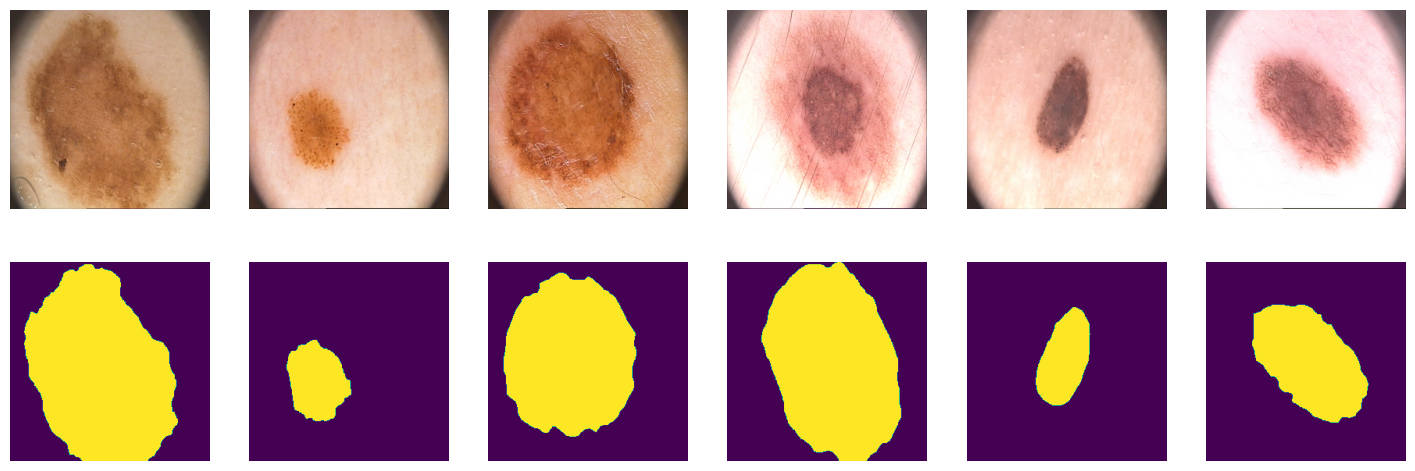

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Let's divide our 200 images into 100/50/50
for training, validation and test, respectively

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet 

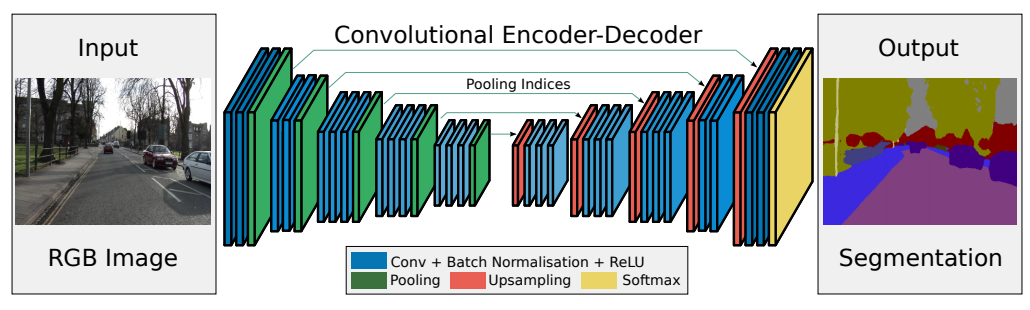

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        
        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1))
        

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))


        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation
        return d3

## Мetrics

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$




![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         

    iou = (intersection + SMOOTH) / (union + SMOOTH)  

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 

    return thresholded  #

## Loss function



$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Train function



In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric, scheduler):
    X_val, Y_val = next(iter(data_val))
    losses_train = list()
    losses_val = list()
    scores_train = list()
    scores_val = list()
    history = list()
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        tr_scores = 0
        vl_scores = 0
        avg_loss = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            opt.zero_grad()
            
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward()  
            opt.step()  

            
            avg_loss += loss / len(data_tr)
            tr_scores += metric((torch.sigmoid(Y_pred)>0.5).int(), Y_batch).mean().item()
        scores_train.append(tr_scores/len(data_tr))
        toc = time()
        losses_train.append(avg_loss)
        print('loss: %f' % avg_loss)
        scheduler.step()

        
        model.eval()  
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu() 
            val_loss = loss_fn(Y_val, Y_hat)
            losses_val.append(val_loss.item())
            Y_hat = (torch.sigmoid(Y_hat)>0.5).int()
            vl_scores += metric(Y_hat, Y_val).mean().item()
        scores_val.append(vl_scores/len(data_val))
        
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    history.append((losses_train, scores_train, losses_val, scores_val))
    return history

## Inference

In [ ]:
def predict(model, data):
    model.eval()  
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  
    scores = 0
    for X_batch, Y_batch in data:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        with torch.no_grad():
            Y_pred = (torch.sigmoid((model(X_batch)))>0.5).int()
            scores += metric(Y_pred, Y_batch).mean().item()

    return scores/len(data)

## Fitting


### Segnet with BCE loss

In [ ]:
model = SegNet().to(device)

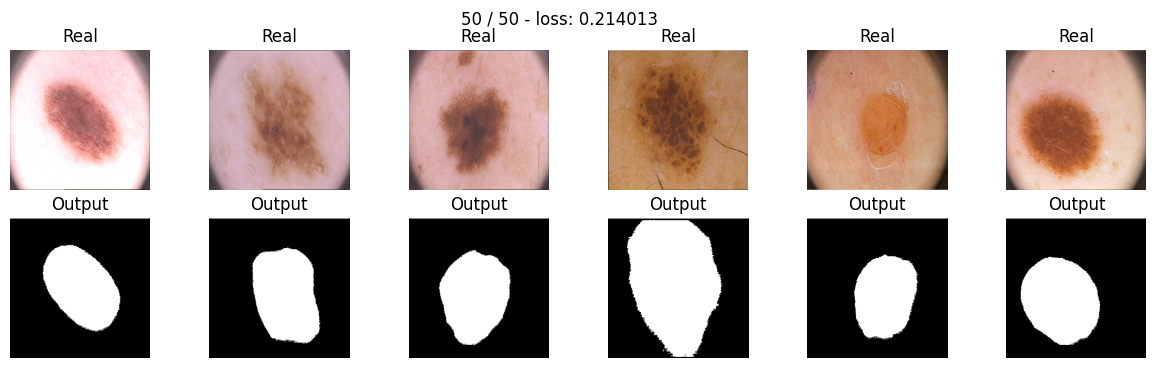

In [ ]:
max_epochs = 50
optimizer = optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
history_segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6480000019073486

In [ ]:
loss_seg_bce, acc_seg_bce, val_loss_seg_bce, val_acc_seg_bce = zip(*history_segnet_bce)

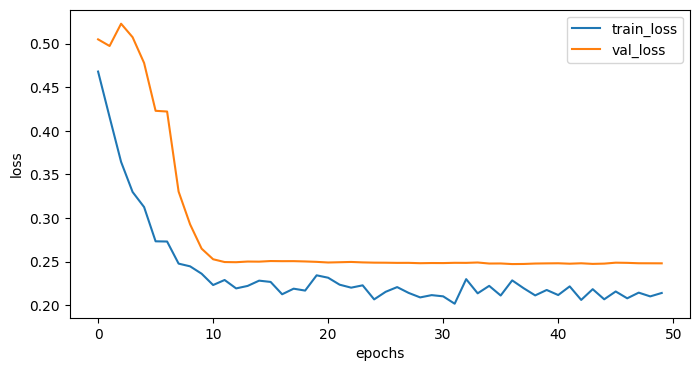

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_bce[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_bce[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

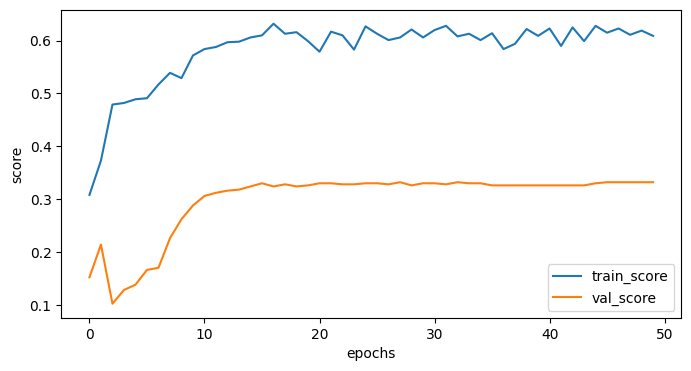

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_bce[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

#### Different learning rate

lr = 0.00001

In [ ]:
model_0_00001 = SegNet().to(device)

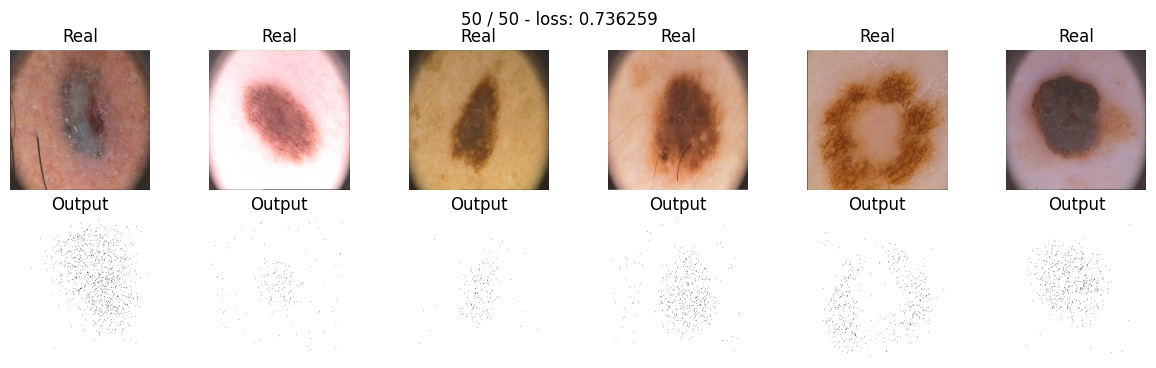

In [ ]:
max_epochs = 50
optimizer1 = optim.Adam(model_0_00001.parameters(), lr=0.00001)
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)
history_segnet_bce1 = train(model_0_00001, optimizer1, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler1)

In [ ]:
loss_seg_bce1, acc_seg_bce1, val_loss_seg_bce1, val_acc_seg_bce1 = zip(*history_segnet_bce1)

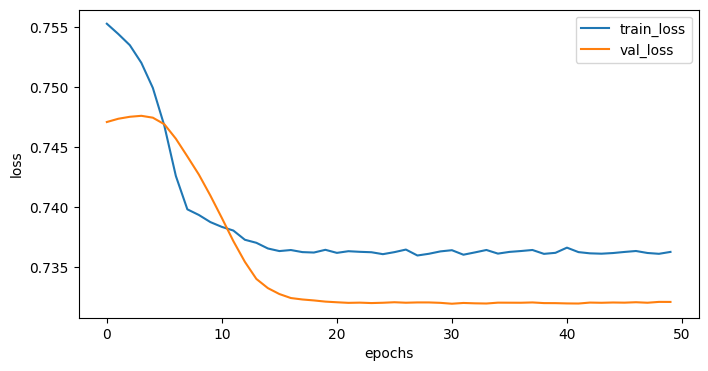

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_bce1[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_bce1[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

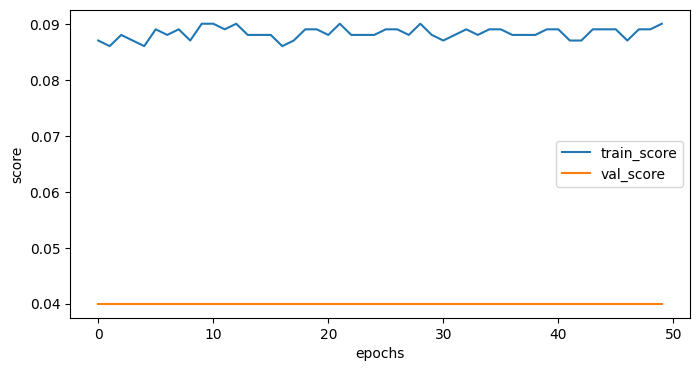

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce1[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_bce1[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model_0_00001, iou_pytorch, data_val)

0.12000000476837158

lr = 1e-3

In [ ]:
model_1e_3 = SegNet().to(device)

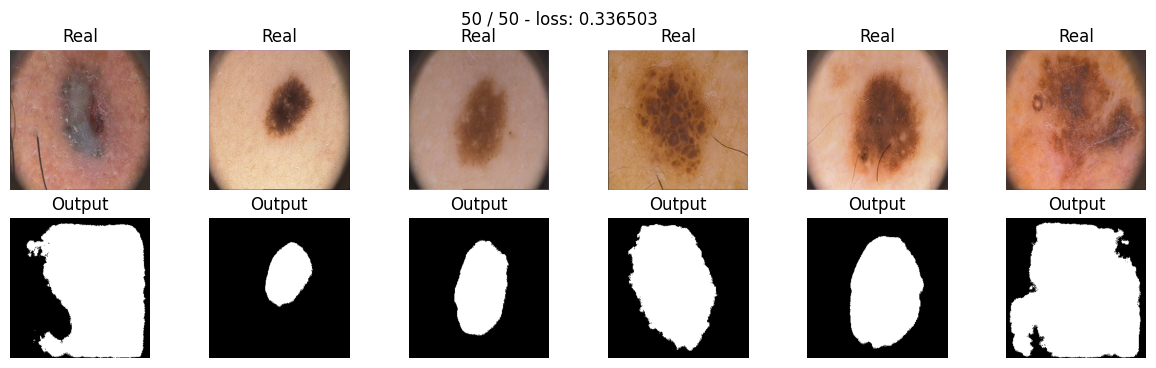

In [ ]:
max_epochs = 50
optimizer2 = optim.Adam(model_1e_3.parameters(), lr=1e-3)
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)
history_segnet_bce2 = train(model_1e_3, optimizer2, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler2)

In [ ]:
loss_seg_bce2, acc_seg_bce2, val_loss_seg_bce2, val_acc_seg_bce2 = zip(*history_segnet_bce2)

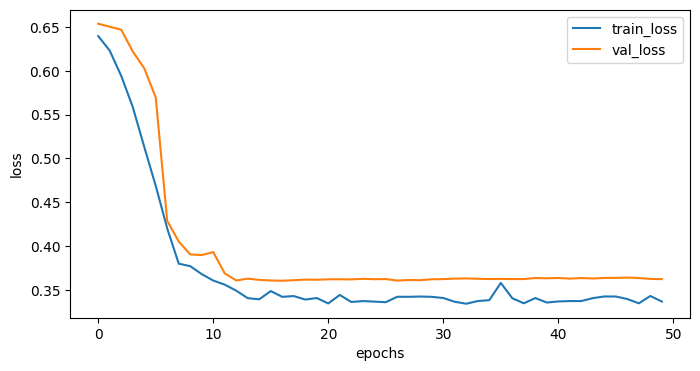

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_bce2[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_bce2[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

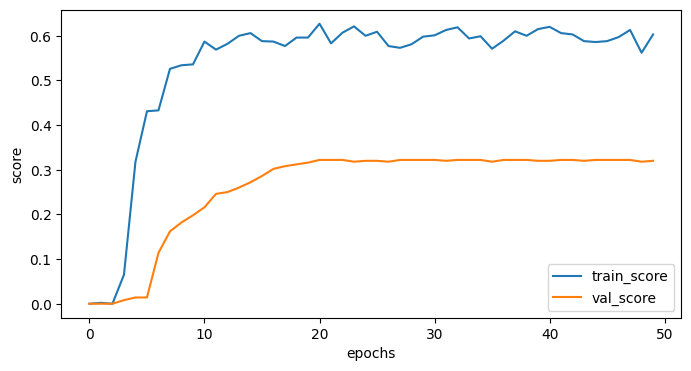

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce2[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_bce2[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model_1e_3, iou_pytorch, data_val)

0.6340000033378601

lr = 1e-4

In [ ]:
model_1e_4 = SegNet().to(device)

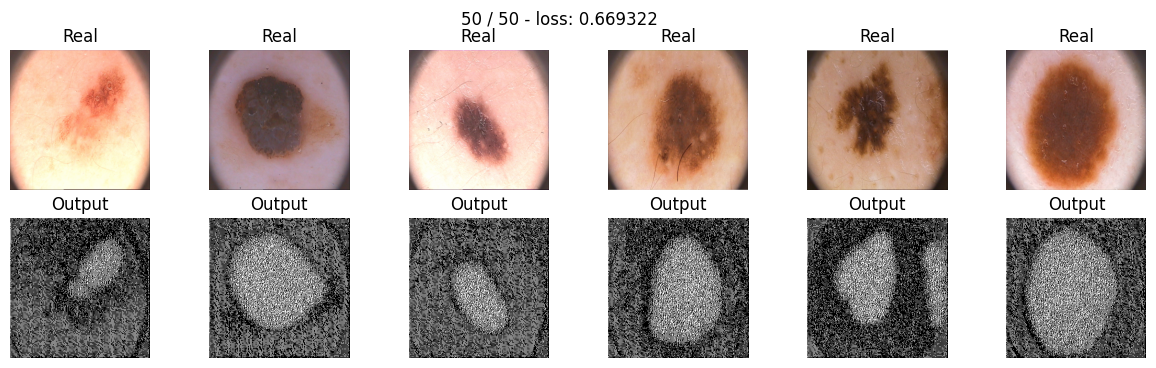

In [ ]:
max_epochs = 50
optimizer3 = optim.Adam(model_1e_4.parameters(), lr=1e-4)
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.1)
history_segnet_bce3 = train(model_1e_4, optimizer3, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler3)

In [ ]:
loss_seg_bce3, acc_seg_bce3, val_loss_seg_bce3, val_acc_seg_bce3 = zip(*history_segnet_bce3)

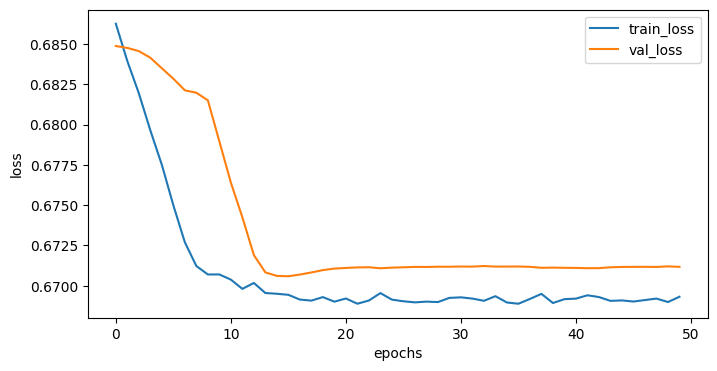

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_bce3[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_bce3[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

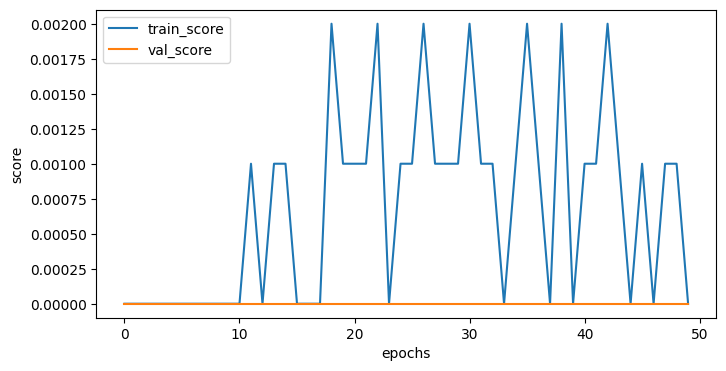

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce3[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_bce3[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model_1e_4, iou_pytorch, data_val)

0.0

In [ ]:
model_3e_4 = SegNet().to(device)

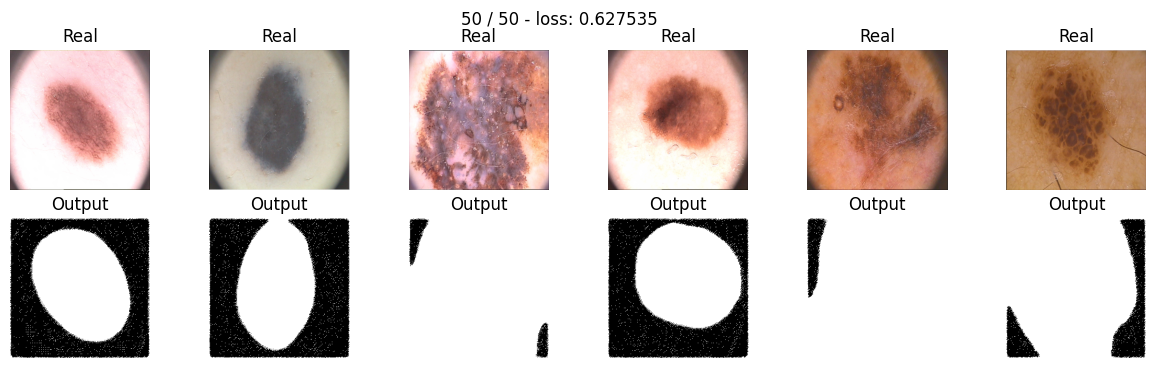

In [ ]:
max_epochs = 50
optimizer4 = optim.Adam(model_3e_4.parameters(), lr=3e-4)
exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer4, step_size=7, gamma=0.1)
history_segnet_bce4 = train(model_3e_4, optimizer4, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler4)

In [ ]:
loss_seg_bce4, acc_seg_bce4, val_loss_seg_bce4, val_acc_seg_bce4 = zip(*history_segnet_bce4)

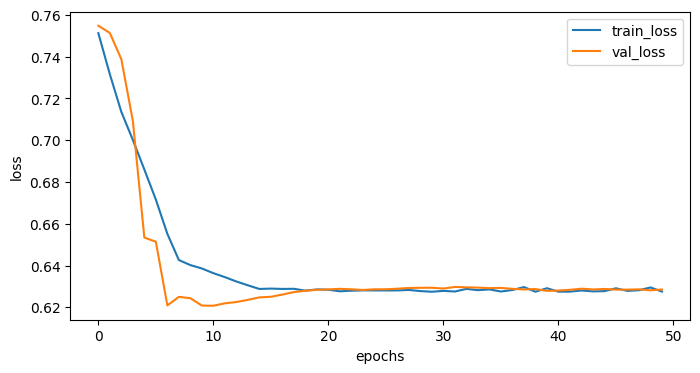

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_bce4[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_bce4[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

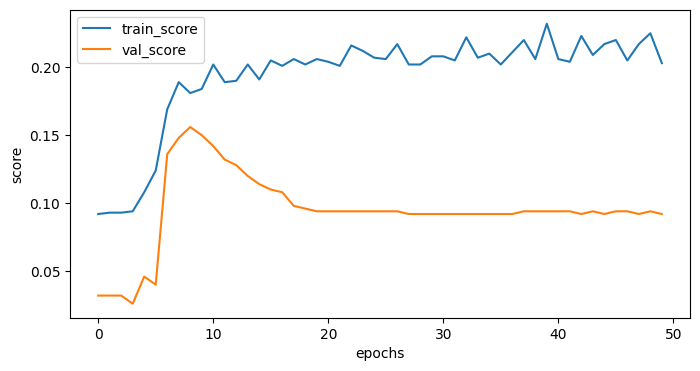

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce4[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_bce4[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model_3e_4, iou_pytorch, data_val)

0.23600000888109207

-----------------------------------------------------------------------------------------

## DICE and Focal loss

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.




$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$



$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$




In [ ]:
def dice_loss(y_real, y_pred):
    # num = (1 / (256 * 256))
    y_pred = torch.sigmoid(y_pred)
    den = (torch.mean(2 * y_real * y_pred)) / (torch.mean(y_real + y_pred))
    res = 1 - den
    return res

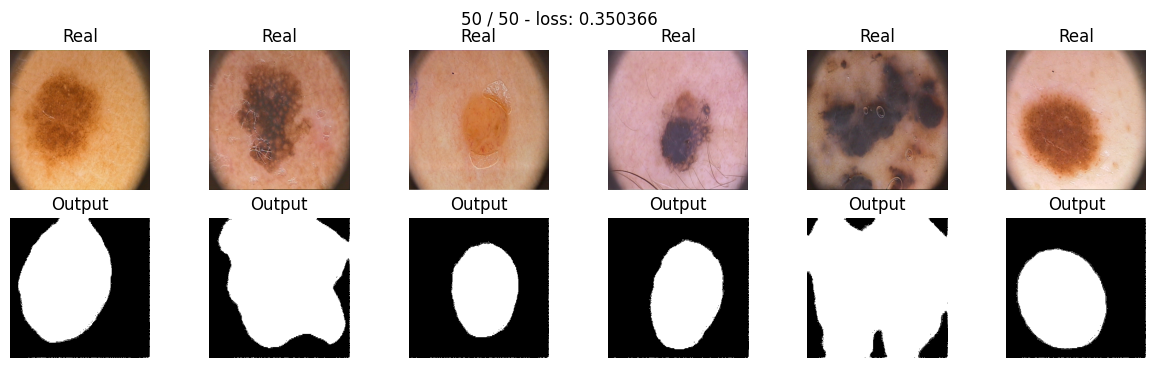

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer_segnet_dice = optim.Adam(model_dice.parameters())
exp_lr_scheduler_segnet_dice = lr_scheduler.StepLR(optimaizer_segnet_dice, step_size=7, gamma=0.1)
history_segnet_dice = train(model_dice, optimaizer_segnet_dice, dice_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler_segnet_dice)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.4699999988079071

In [ ]:
loss_seg_dice, acc_seg_dice, val_loss_seg_dice, val_acc_seg_dice = zip(*history_segnet_dice)

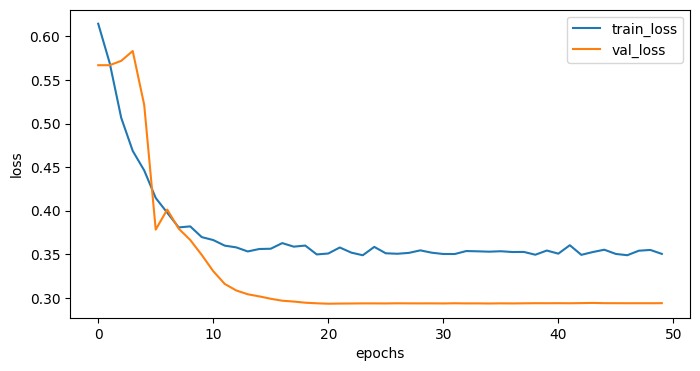

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_dice[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_dice[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

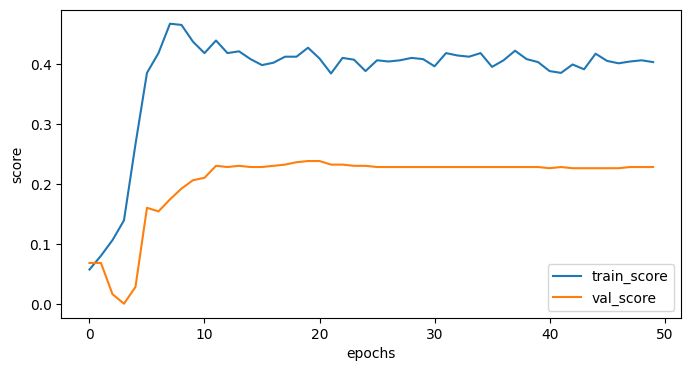

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_dice[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_dice[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)



$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

 $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred) # hint: torch.clamp
    return -torch.mean((1 - y_pred) ** gamma * y_real * torch.log(y_pred + eps) + (1 - y_real) * torch.log(1 - y_pred + eps))

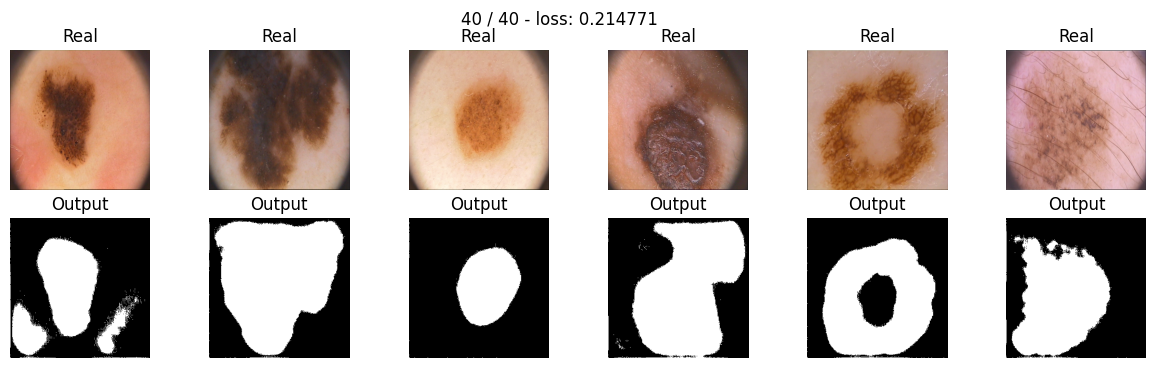

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer_segnet_focal = optim.Adam(model_focal.parameters())
exp_lr_scheduler_segnet_focal = lr_scheduler.StepLR(optimaizer_segnet_focal, step_size=7, gamma=0.1)
history_segnet_focal = train(model_focal, optimaizer_segnet_focal, focal_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler_segnet_focal)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.636000007390976

In [ ]:
loss_seg_focal, acc_seg_focal, val_loss_seg_focal, val_acc_seg_focal = zip(*history_segnet_focal)

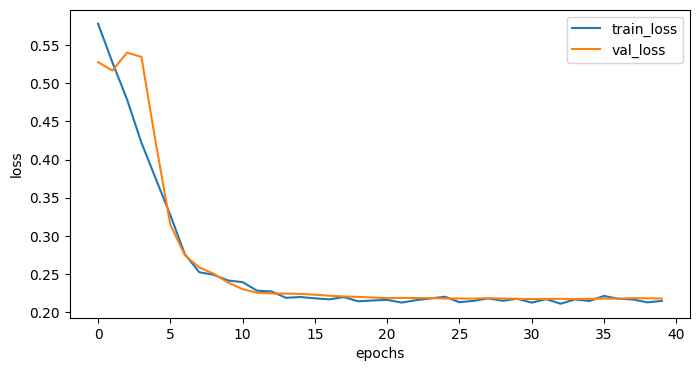

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_focal[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_focal[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

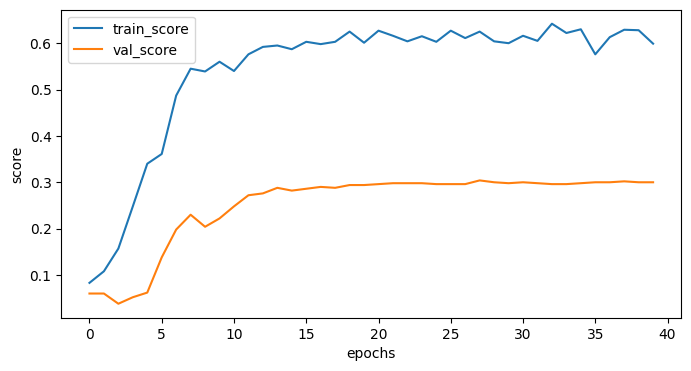

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_focal[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_focal[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
def facial_parts_loss(y_real, y_pred):
    return (1 / len(y_real)) * torch.mean((y_real - y_pred) ** 2)

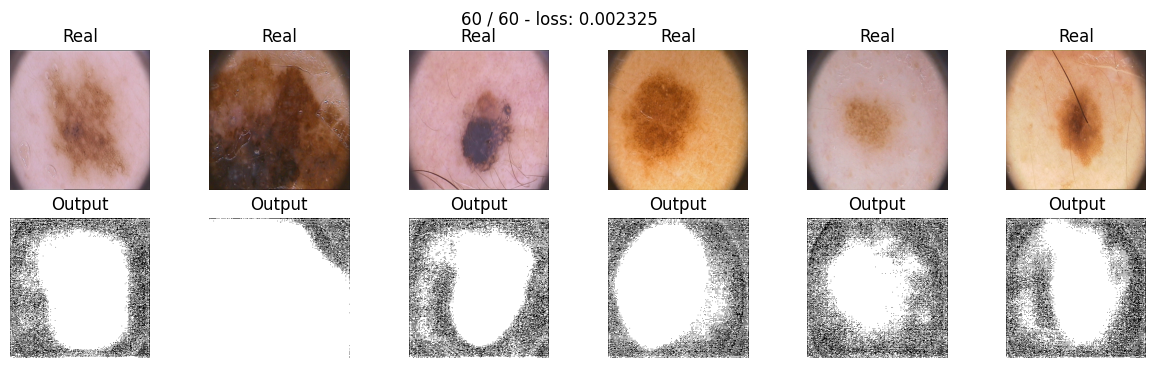

In [ ]:
model_lova = SegNet().to(device)

max_epochs = 60
optimaizer_segnet_lova = optim.Adam(model_lova.parameters())
exp_lr_scheduler_segnet_lova = lr_scheduler.StepLR(optimaizer_segnet_lova, step_size=7, gamma=0.1)
history_segnet_lova = train(model_lova, optimaizer_segnet_lova, facial_parts_loss, max_epochs, data_tr, data_val, iou_pytorch, exp_lr_scheduler_segnet_lova)

In [ ]:
score_model(model_lova, iou_pytorch, data_val)

0.15999998897314072

In [ ]:
loss_seg_fp, acc_seg_fp, val_loss_seg_fp, val_acc_seg_fp = zip(*history_segnet_lova)

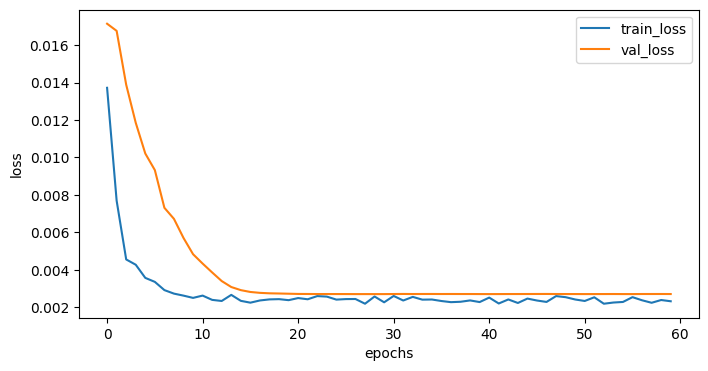

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_seg_fp[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_seg_fp[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

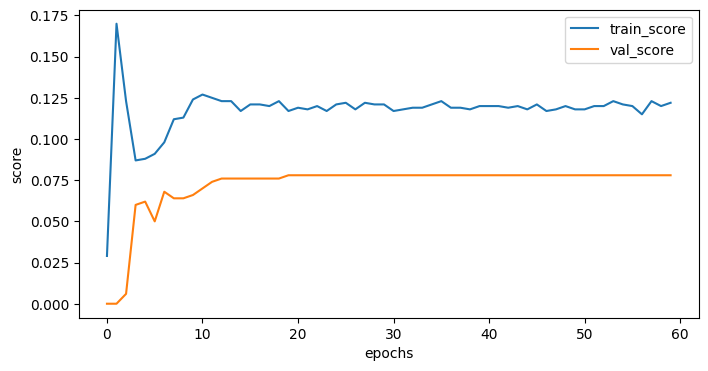

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_fp[0]), label="train_score")
plt.plot(torch.tensor(val_acc_seg_fp[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]



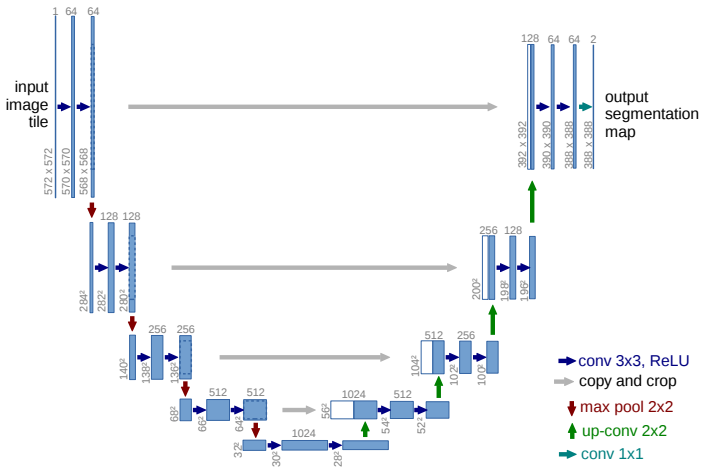

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(),
             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        # self.enc_conv0 =
        # self.pool0 =   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        # self.enc_conv1 =
        # self.pool1 =  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        # self.enc_conv2 =
        # self.pool2 =  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        # self.enc_conv3 =
        # self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        # self.dec_conv0 = nn.Sequential(
            # nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2),
            # nn.ReLU())
        # self.bnd0 = nn.BatchNorm2d(32)
        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        # self.upsample0 =  # 16 -> 32
        # self.dec_conv0 =
        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        # self.upsample1 =  # 32 -> 64
        # self.dec_conv1 =
        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        # self.upsample2 =   # 64 -> 128
        # self.dec_conv2 =
        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1))
        # self.upsample3 =   # 128 -> 256
        # self.dec_conv3 =

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        sc0 = e0.clone()
        # print(e0.shape)
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        sc1 = e1.clone()
        # print(e1.shape)
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        sc2 = e2.clone()
        # print(e2.shape)
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        sc3 = e3.clone()
        # print(e3.shape)


        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b + sc3, ind3))
        # print(d0.shape)
        d1 = self.dec_conv1(self.upsample1(d0 + sc2, ind2))
        # print(d1.shape)
        d2 = self.dec_conv2(self.upsample2(d1 + sc1, ind1))
        # print(d2.shape)
        d3 = self.dec_conv3(self.upsample3(d2 + sc0, ind0))
        # print(d3.shape)  # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

## Unet with BCE loss

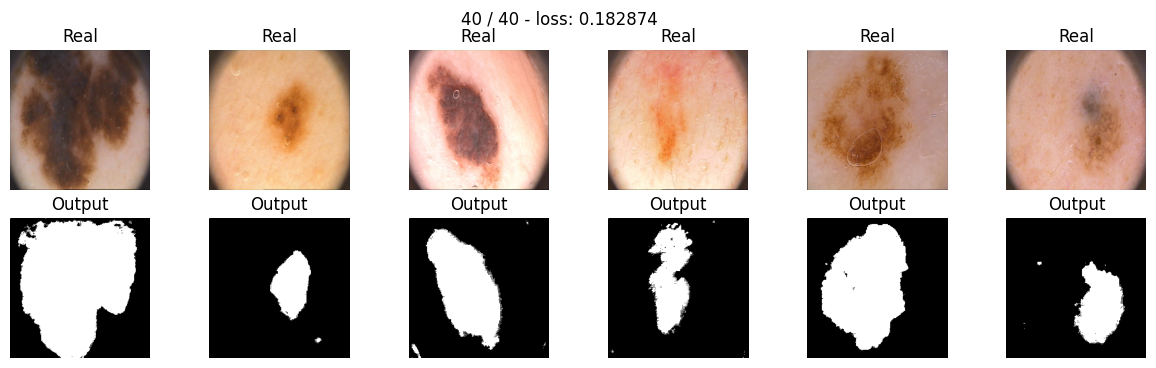

In [ ]:
optimizer_unet_bce = optim.Adam(unet_model.parameters())
exp_lr_scheduler_unet_bce = lr_scheduler.StepLR(optimizer_unet_bce, step_size=7, gamma=0.1)
history_unet1_bce = train(unet_model, optimizer_unet_bce, bce_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet_bce)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6599999964237213

In [ ]:
loss_unet_bce, acc_unet_bce, val_loss_unet_bce, val_acc_unet_bce = zip(*history_unet1_bce)

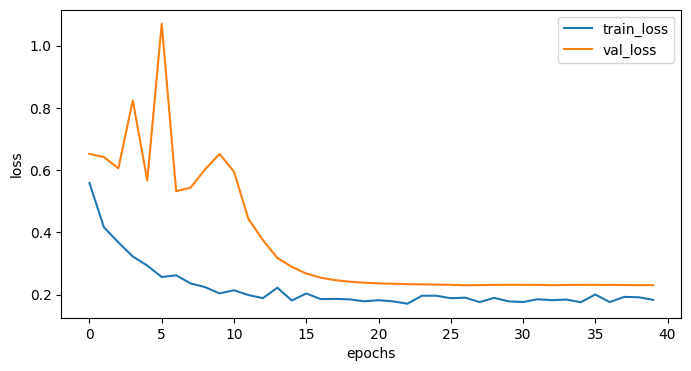

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet_bce[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet_bce[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

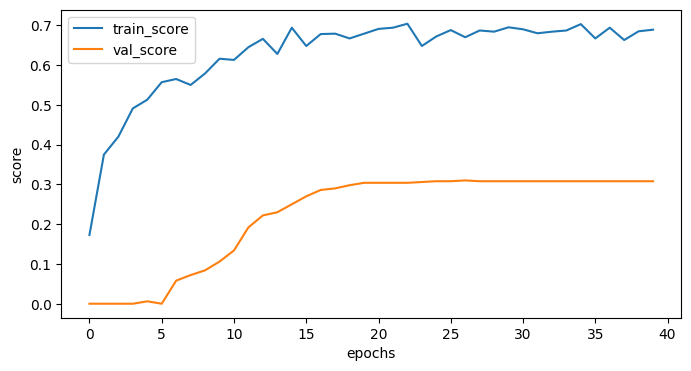

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet_bce[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet_bce[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet with dice Loss

In [ ]:
unet_model_dice = UNet().to(device)

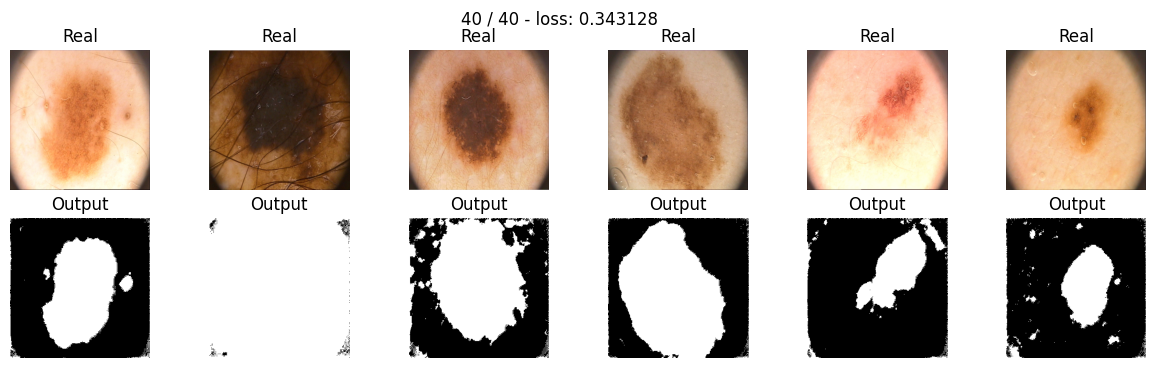

In [ ]:
optimizer_unet_dice = optim.Adam(unet_model_dice.parameters())
exp_lr_scheduler_unet_dice = lr_scheduler.StepLR(optimizer_unet_dice, step_size=7, gamma=0.1)
history_unet1_dice = train(unet_model_dice, optimizer_unet_dice, dice_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet_dice)

In [ ]:
score_model(unet_model_dice, iou_pytorch, data_val)

0.4580000042915344

In [ ]:
loss_unet_dice, acc_unet_dice, val_loss_unet_dice, val_acc_unet_dice = zip(*history_unet1_dice)

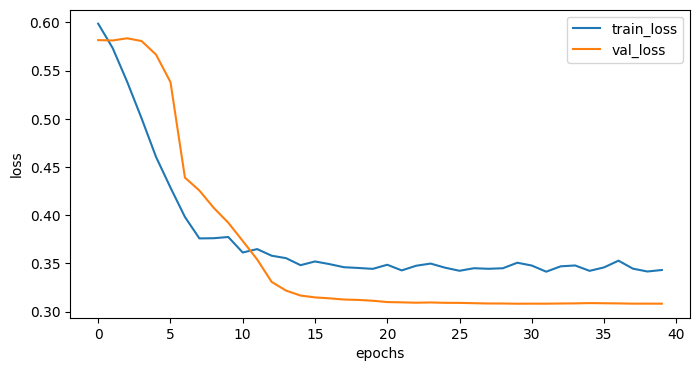

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet_dice[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet_dice[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

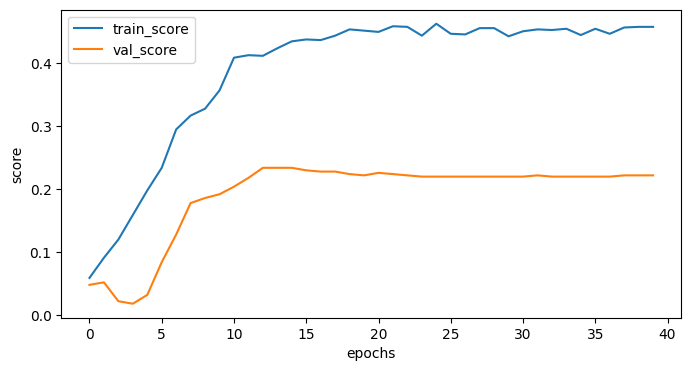

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet_dice[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet_dice[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet with focal loss

In [ ]:
unet_model_focal = UNet().to(device)

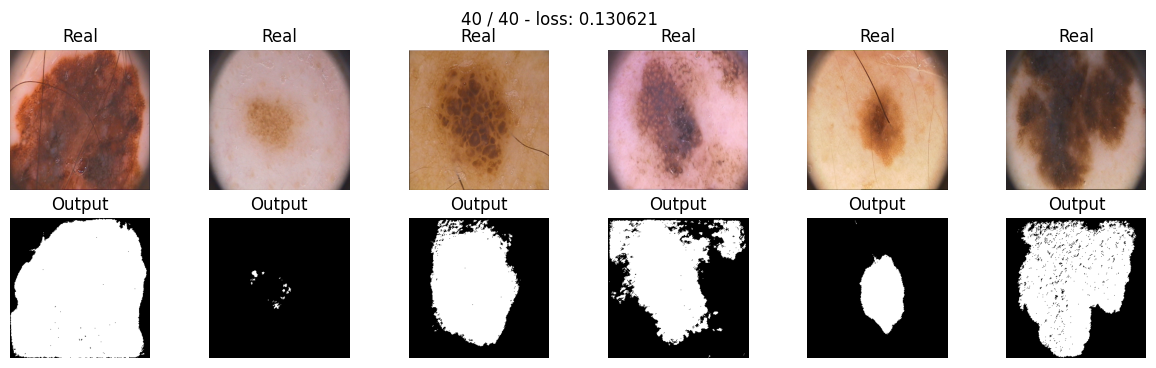

In [ ]:
optimizer_unet_focal = optim.Adam(unet_model_focal.parameters())
exp_lr_scheduler_unet_focal = lr_scheduler.StepLR(optimizer_unet_focal, step_size=7, gamma=0.1)
history_unet1_focal = train(unet_model_focal, optimizer_unet_focal, focal_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet_focal)

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.6260000169277191

In [ ]:
loss_unet_focal, acc_unet_focal, val_loss_unet_focal, val_acc_unet_focal = zip(*history_unet1_focal)

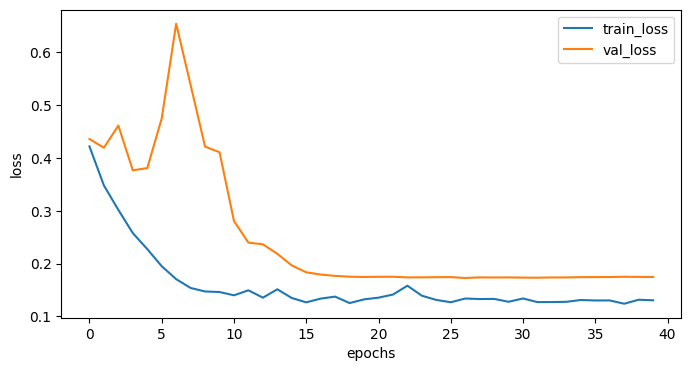

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet_focal[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet_focal[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

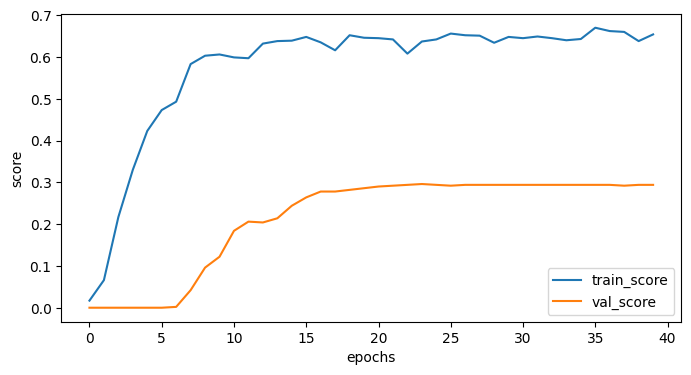

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet_focal[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet_focal[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet with facial_parts loss

In [ ]:
unet_model_fp = UNet().to(device)

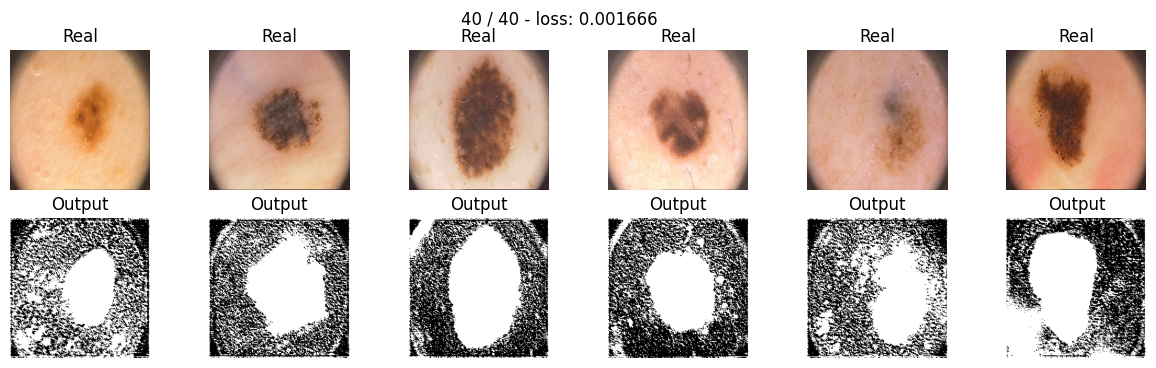

In [ ]:
optimizer_unet_fp = optim.Adam(unet_model_fp.parameters())
exp_lr_scheduler_unet_fp = lr_scheduler.StepLR(optimizer_unet_focal, step_size=7, gamma=0.1)
history_unet1_fp = train(unet_model_fp, optimizer_unet_fp, facial_parts_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet_fp)

In [ ]:
score_model(unet_model_fp, iou_pytorch, data_val)

0.2280000001192093

In [ ]:
loss_unet_fp, acc_unet_fp, val_loss_unet_fp, val_acc_unet_fp = zip(*history_unet1_fp)

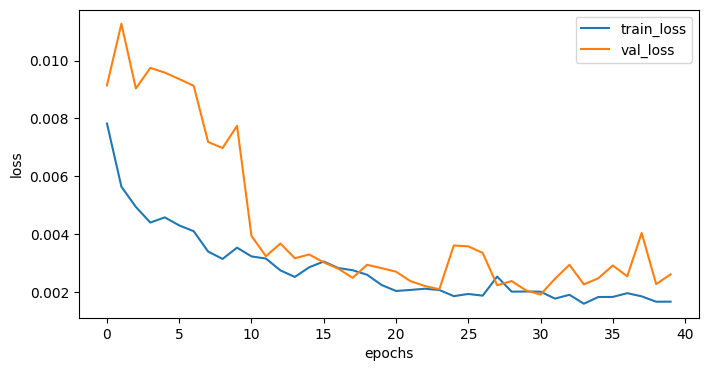

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet_fp[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet_fp[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

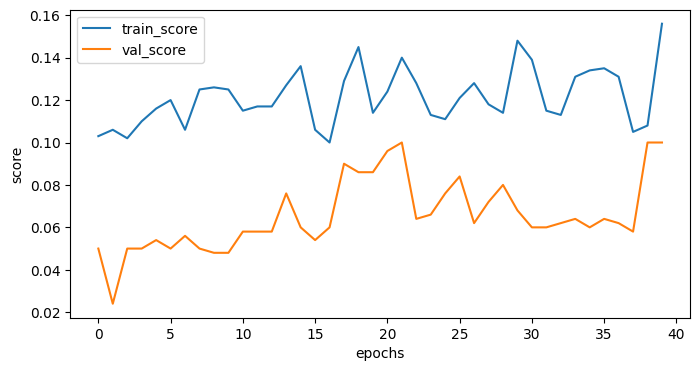

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet_fp[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet_fp[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet2



In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU(),
             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
             nn.BatchNorm2d(64),
             nn.ReLU())
        self.pool0 = nn.MaxPool2d(3, 2, padding=1, return_indices=True)
        # self.enc_conv0 =
        # self.pool0 =   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.pool1 = nn.MaxPool2d(3, 2, padding=1, return_indices=True)
        # self.enc_conv1 =
        # self.pool1 =  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool2 = nn.MaxPool2d(3, 2, padding=1, return_indices=True)
        # self.enc_conv2 =
        # self.pool2 =  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.pool3 = nn.MaxPool2d(3, 2, padding=1, return_indices=True)
        # self.enc_conv3 =
        # self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        # self.dec_conv0 = nn.Sequential(
            # nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2),
            # nn.ReLU())
        # self.bnd0 = nn.BatchNorm2d(32)
        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        # self.upsample0 =  # 16 -> 32
        # self.dec_conv0 =
        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        # self.upsample1 =  # 32 -> 64
        # self.dec_conv1 =
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        # self.upsample2 =   # 64 -> 128
        # self.dec_conv2 =
        self.upsample3 = nn.Upsample(256)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1))
        # self.upsample3 =   # 128 -> 256
        # self.dec_conv3 =

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        sc0 = e0.clone()
        # print(e0.shape)
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        sc1 = e1.clone()
        # print(e1.shape)
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        sc2 = e2.clone()
        # print(e2.shape)
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        sc3 = e3.clone()
        # print(e3.shape)


        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b + sc3))
        # print(d0.shape)
        d1 = self.dec_conv1(self.upsample1(d0 + sc2))
        # print(d1.shape)
        d2 = self.dec_conv2(self.upsample2(d1 + sc1))
        # print(d2.shape)
        d3 = self.dec_conv3(self.upsample3(d2 + sc0))
        # print(d3.shape)  # no activation
        return d3

## Unet2 c BCE лоссом

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
optimizer_unet2_bce = optim.Adam(unet2_model.parameters())
exp_lr_scheduler_unet2_bce = lr_scheduler.StepLR(optimizer_unet2_bce, step_size=7, gamma=0.1)

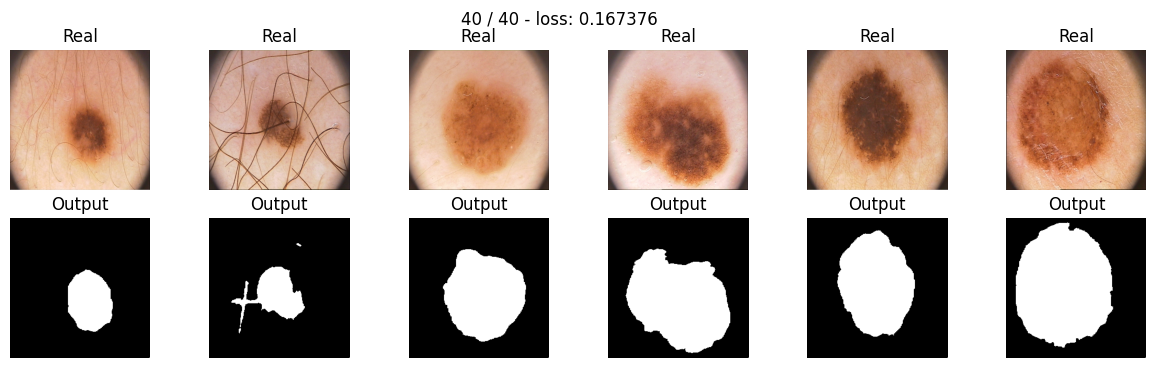

In [ ]:
history_unet2_bce = train(unet2_model, optimizer_unet2_bce, bce_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet2_bce)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.6699999868869781

In [ ]:
loss_unet2_bce, acc_unet2_bce, val_loss_unet2_bce, val_acc_unet2_bce = zip(*history_unet2_bce)

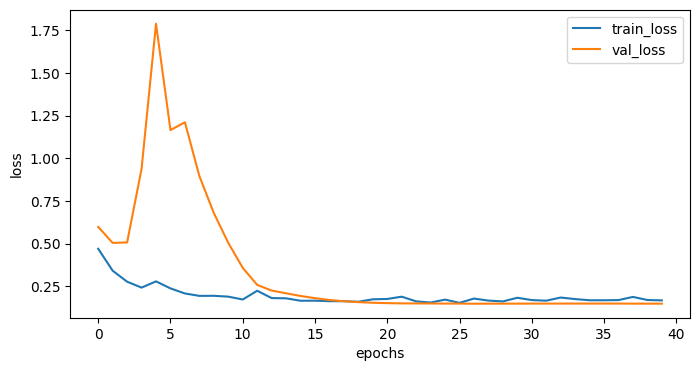

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet2_bce[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet2_bce[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

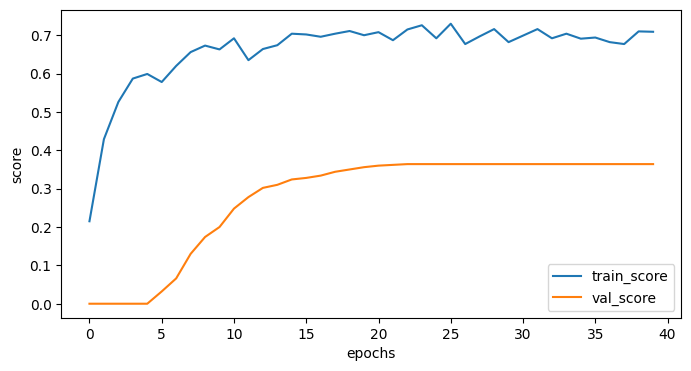

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet2_bce[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet2_bce[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet2 with dice loss

In [ ]:
unet2_model_dice = UNet2().to(device)

In [ ]:
optimizer_unet2_dice = optim.Adam(unet2_model_dice.parameters())
exp_lr_scheduler_unet2_dice = lr_scheduler.StepLR(optimizer_unet2_dice, step_size=7, gamma=0.1)

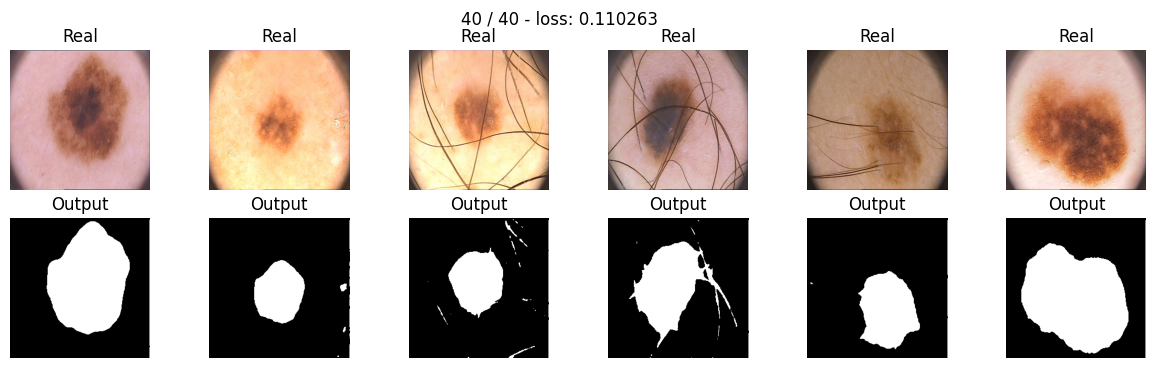

In [ ]:
history_unet2_dice = train(unet2_model_dice, optimizer_unet2_dice, dice_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet2_dice)

In [ ]:
score_model(unet2_model_dice, iou_pytorch, data_val)

0.6420000195503235

In [ ]:
loss_unet2_dice, acc_unet2_dice, val_loss_unet2_dice, val_acc_unet2_dice = zip(*history_unet2_dice)

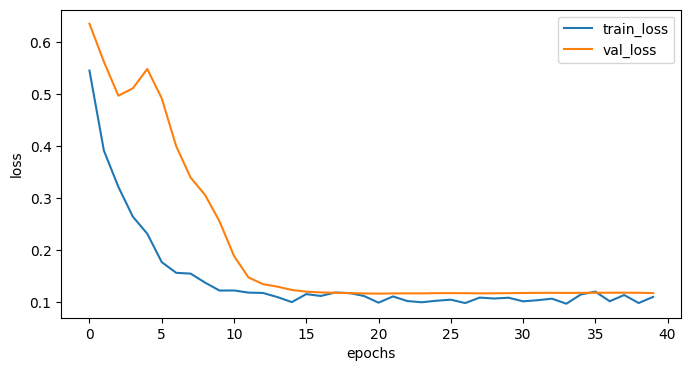

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet2_dice[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet2_dice[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

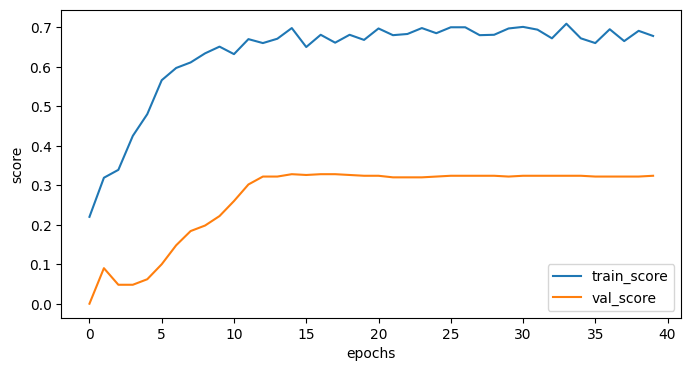

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet2_dice[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet2_dice[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet2 with focal loss

In [ ]:
unet2_model_focal = UNet2().to(device)

In [ ]:
optimizer_unet2_focal = optim.Adam(unet2_model_focal.parameters())
exp_lr_scheduler_unet2_focal = lr_scheduler.StepLR(optimizer_unet2_focal, step_size=7, gamma=0.1)

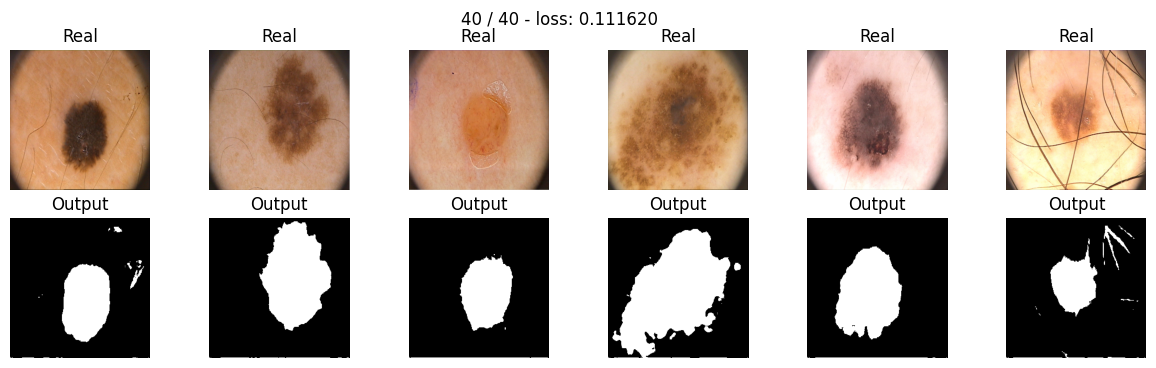

In [ ]:
history_unet2_focal = train(unet2_model_focal, optimizer_unet2_focal, focal_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet2_focal)

In [ ]:
score_model(unet2_model_focal, iou_pytorch, data_val)

0.6239999830722809

In [ ]:
loss_unet2_focal, acc_unet2_focal, val_loss_unet2_focal, val_acc_unet2_focal = zip(*history_unet2_focal)

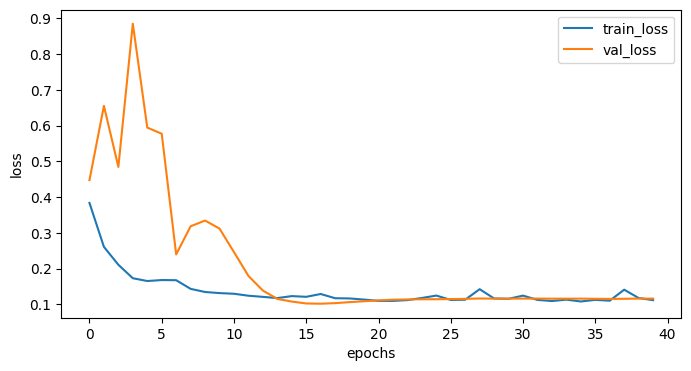

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet2_focal[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet2_focal[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

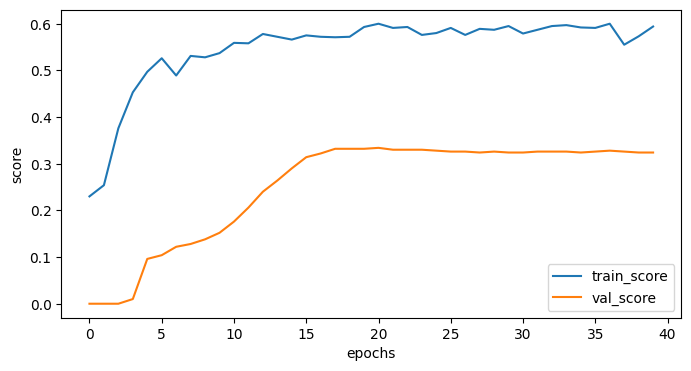

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet2_focal[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet2_focal[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## Unet2 with facial_parts loss

In [ ]:
unet2_model_fp = UNet2().to(device)

In [ ]:
optimizer_unet2_fp = optim.Adam(unet2_model_fp.parameters())
exp_lr_scheduler_unet2_fp = lr_scheduler.StepLR(optimizer_unet2_fp, step_size=7, gamma=0.1)

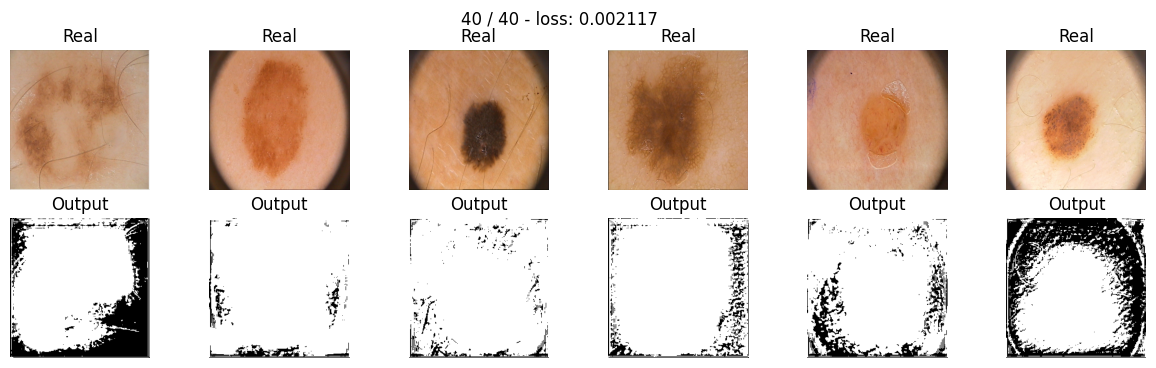

In [ ]:
history_unet2_fp = train(unet2_model_fp, optimizer_unet2_fp, facial_parts_loss, 40, data_tr, data_val, iou_pytorch, exp_lr_scheduler_unet2_fp)

In [ ]:
score_model(unet2_model_fp, iou_pytorch, data_val)

0.13000000268220901

In [ ]:
loss_unet2_fp, acc_unet2_fp, val_loss_unet2_fp, val_acc_unet2_fp = zip(*history_unet2_fp)

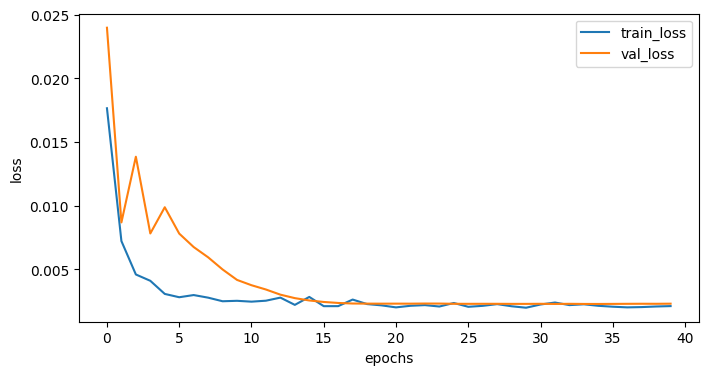

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(loss_unet2_fp[0]), label="train_loss")
plt.plot(torch.tensor(val_loss_unet2_fp[0]), label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

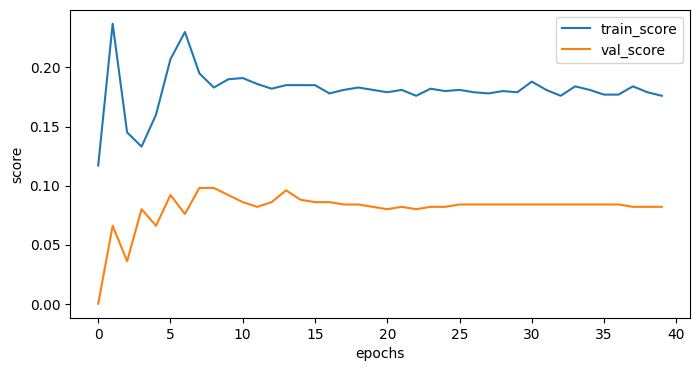

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_unet2_fp[0]), label="train_score")
plt.plot(torch.tensor(val_acc_unet2_fp[0]), label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
del model_1e_4
del optimizer3
gc.collect()

30781

# Report

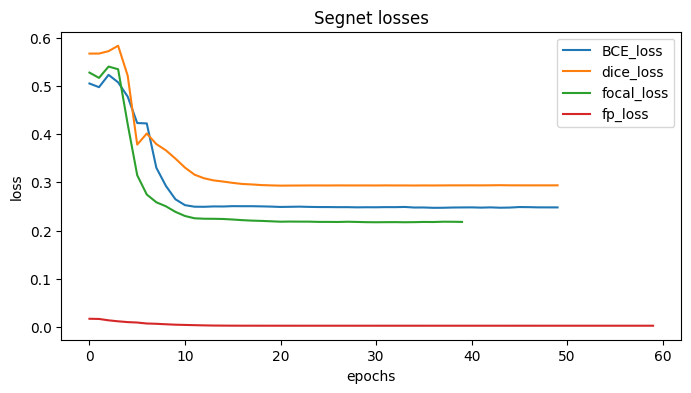

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Segnet losses')
plt.plot(torch.tensor(val_loss_seg_bce[0]), label="BCE_loss")
plt.plot(torch.tensor(val_loss_seg_dice[0]), label="dice_loss")
plt.plot(torch.tensor(val_loss_seg_focal[0]), label="focal_loss")
plt.plot(torch.tensor(val_loss_seg_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

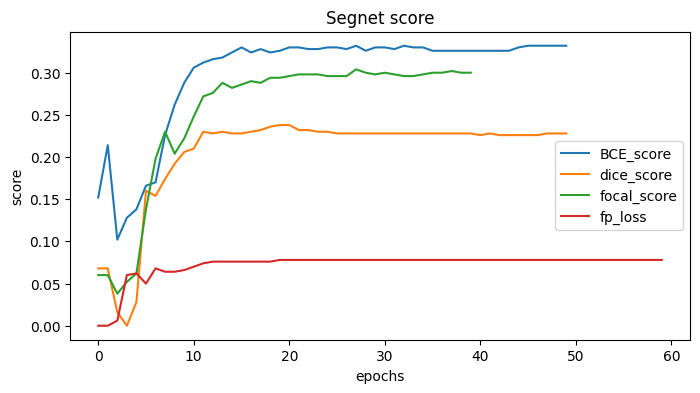

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Segnet score')
plt.plot(torch.tensor(val_acc_seg_bce[0]), label="BCE_score")
plt.plot(torch.tensor(val_acc_seg_dice[0]), label="dice_score")
plt.plot(torch.tensor(val_acc_seg_focal[0]), label="focal_score")
plt.plot(torch.tensor(val_acc_seg_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.6539999842643738

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.44999998807907104

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

0.6180000007152557

In [ ]:
score_model(model_lova, iou_pytorch, data_ts)

0.12999999523162842

Final scores Segnet :
* BCE: 0.65
* dice: 0.45
* focal: 0.61
* facial_parts: 0.13

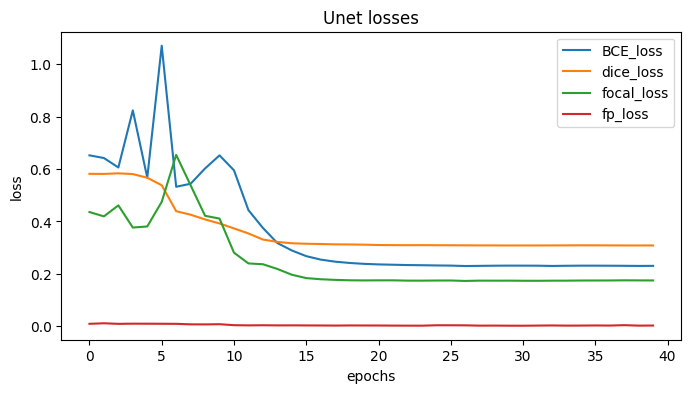

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Unet losses')
plt.plot(torch.tensor(val_loss_unet_bce[0]), label="BCE_loss")
plt.plot(torch.tensor(val_loss_unet_dice[0]), label="dice_loss")
plt.plot(torch.tensor(val_loss_unet_focal[0]), label="focal_loss")
plt.plot(torch.tensor(val_loss_unet_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

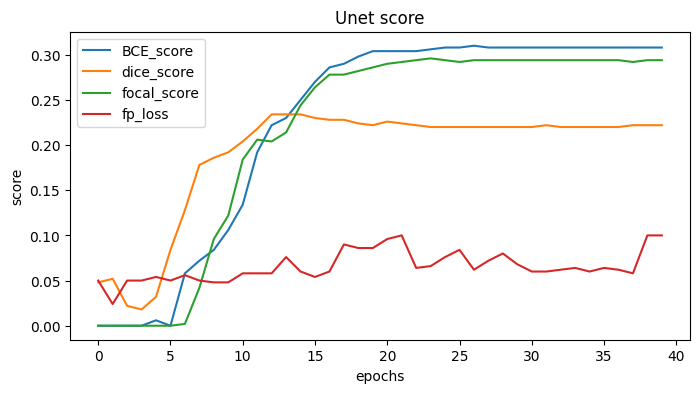

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Unet score')
plt.plot(torch.tensor(val_acc_unet_bce[0]), label="BCE_score")
plt.plot(torch.tensor(val_acc_unet_dice[0]), label="dice_score")
plt.plot(torch.tensor(val_acc_unet_focal[0]), label="focal_score")
plt.plot(torch.tensor(val_acc_unet_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(unet_model, iou_pytorch, data_ts)

0.7000000178813934

In [ ]:
score_model(unet_model_dice, iou_pytorch, data_ts)

0.5180000066757202

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_ts)

0.6799999475479126

In [ ]:
score_model(unet_model_fp, iou_pytorch, data_ts)

0.17799999937415123

Final  Unet scores
* BCE: 0.7
* dice: 0.52
* focal: 0.68
* fp: 0.18

Unet2 with MaxPool2d(3, 2, padding=1) и nn.Upsample

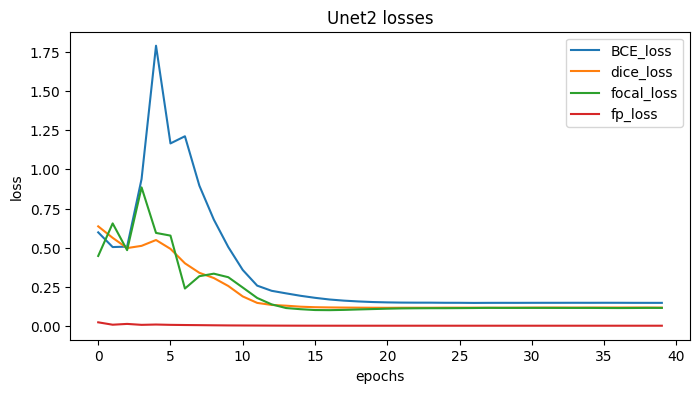

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Unet2 losses')
plt.plot(torch.tensor(val_loss_unet2_bce[0]), label="BCE_loss")
plt.plot(torch.tensor(val_loss_unet2_dice[0]), label="dice_loss")
plt.plot(torch.tensor(val_loss_unet2_focal[0]), label="focal_loss")
plt.plot(torch.tensor(val_loss_unet2_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

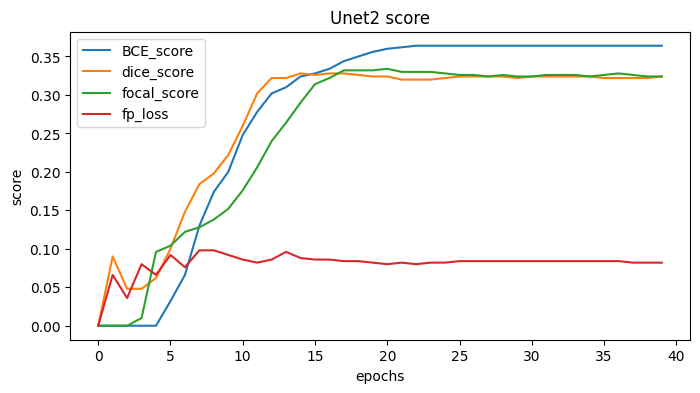

In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Unet2 score')
plt.plot(torch.tensor(val_acc_unet2_bce[0]), label="BCE_score")
plt.plot(torch.tensor(val_acc_unet2_dice[0]), label="dice_score")
plt.plot(torch.tensor(val_acc_unet2_focal[0]), label="focal_score")
plt.plot(torch.tensor(val_acc_unet2_fp[0]), label="fp_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(unet2_model, iou_pytorch, data_ts)

0.629999965429306

In [ ]:
score_model(unet2_model_dice, iou_pytorch, data_ts)

0.6400000154972076

In [ ]:
score_model(unet2_model_focal, iou_pytorch, data_ts)

0.5640000104904175

In [ ]:
score_model(unet2_model_fp, iou_pytorch, data_ts)

0.09200000762939453

Final Unet2 scores
* BCE: 0.63
* dice: 0.64
* focal: 0.56
* fp: 0.1

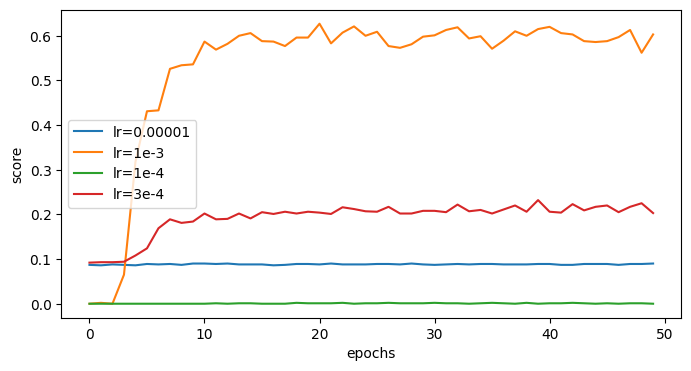

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(torch.tensor(acc_seg_bce1[0]), label="lr=0.00001")
plt.plot(torch.tensor(acc_seg_bce2[0]), label="lr=1e-3")
plt.plot(torch.tensor(acc_seg_bce3[0]), label="lr=1e-4")
plt.plot(torch.tensor(acc_seg_bce4[0]), label="lr=3e-4")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

lr = 1e-3 дал результат лучше, чем все остальные, но без подобранного lr скор примерно такой же

3 models were implemented: Segnet with 4 encoder layers and 4 decoder layers and a bottleneck layer, Unet with the same architecture, differing only in skip connection and Unet2, in which the type of pooling and upsampling was changed. All models were tested with 4 different losses, the best on all models except the last one was the BCE loss, but on Unet2 the result with dice loss does not greatly exceed the result with BCE loss. The facial_parts loss taken from the article performed poorly when trying to learn on any number of epochs. It was expected to get a higher score on all models, but attempts to change the parameters according to the lr type did not lead to anything, but the scheduler came in handy. The networks were similar in architecture, only the details differed. The Unet model proved to be the best. Conclusion: Unet shows itself very well, perhaps the speed could be even better with more precisely selected hyperparameters, all models learn better with BCE loss than with other losses. In my opinion, Unet2 has the clearest pictures, so perhaps it is better after all.